<a href="https://colab.research.google.com/github/reginasar/DL_models/blob/main/colab/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-mnist
!pip install umap-learn[plot]
#!pip install holoviews
#!pip install -U ipykernel

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
import numpy as np
import matplotlib.pyplot as plt
import umap

2023-08-29 13:53:03.726815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 13:53:06.578120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def encoder(base_depth, indim, encoder_dim, variational=False, prior=[]):
    seq_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=indim),
    tf.keras.layers.Conv2D(filters=base_depth, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=base_depth, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=base_depth, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=base_depth, kernel_size=2, padding="valid", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten()])

    if variational:
        seq_model.add(tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(encoder_dim), activation=None))
        seq_model.add(tfp.layers.MultivariateNormalTriL(encoder_dim, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=0.6)))
    else:
        seq_model.add(tf.keras.layers.Dense(encoder_dim))

    return seq_model


def decoder(base_depth, encoder_dim, outdim, variational=False, distrib=''):
    seq_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=[encoder_dim]),
    tf.keras.layers.Reshape([1, 1, encoder_dim]),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2DTranspose(filters=base_depth, kernel_size=2, padding="valid", activation="relu"),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2DTranspose(filters=base_depth, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2DTranspose(filters=base_depth, kernel_size=3, padding="valid", activation="relu"),
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", activation=None)])

    if variational:
        seq_model.add(tf.keras.layers.Flatten())
        if distrib=='Normal' or distrib=='normal':
            seq_model.add(tf.keras.layers.Dense(tfp.layers.IndependentNormal.params_size(outdim), activation=None))
            seq_model.add(tfp.layers.IndependentNormal(outdim, tfp.distributions.Normal.sample))
        elif distrib=='Bernoulli' or distrib=='bernoulli':
            seq_model.add(tf.keras.layers.Dense(tfp.layers.IndependentBernoulli.params_size(outdim), activation=None))
            seq_model.add(tfp.layers.IndependentBernoulli(outdim, tfp.distributions.Bernoulli.logits))

    return seq_model





In [4]:
input_shape = (28,28,1)
base_depth = 16
encoded_size = 10
batch_size = 128
epochs = 5
optimizer = "Adam"
loss = "mse"
learning_rate = 1e-3
metrics = "mse"
path_model = "./"
variational = True
distribution = "Bernoulli"

In [5]:
#--------load data--------------------------------
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#-------------------------------------------------

rng = np.random.default_rng(seed=12345)
perm_indices = rng.permutation(np.arange(x_train.shape[0]))

x_val = np.copy(x_train[perm_indices[:5000], :, :, np.newaxis]) / 255.
y_val = np.copy(y_train[perm_indices[:5000]])

x_train = np.copy(x_train[perm_indices[5000:], :, :, np.newaxis]) / 255.
y_train = np.copy(y_train[perm_indices[5000:]])



In [6]:
if variational:
    loss = lambda x, rv_x: -rv_x.log_prob(x) #negloglik
    prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(encoded_size), scale=1), reinterpreted_batch_ndims=1)
    encoder_ = encoder(base_depth, input_shape, encoded_size, variational, prior)
    decoder_ = decoder(base_depth, encoded_size, input_shape, variational, distribution)
else:
    encoder_ = encoder(base_depth, input_shape, encoded_size, variational)
    decoder_ = decoder(base_depth, encoded_size, input_shape, variational)

encoder_.summary()
decoder_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 16)         0

In [7]:
ae = tf.keras.Model(inputs=encoder_.inputs, outputs=decoder_(encoder_.outputs[0]))

ae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

hist = ae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, x_val))

Epoch 1/5
430/430 [==============================] - 130s 285ms/step - loss: 207.4021 - mse: 36.9018 - val_loss: 194.0783 - val_mse: 43.4666
Epoch 2/5
430/430 [==============================] - 98s 229ms/step - loss: 188.7451 - mse: 44.5713 - val_loss: 180.8859 - val_mse: 49.4390
Epoch 3/5
430/430 [==============================] - 98s 227ms/step - loss: 173.7125 - mse: 51.9904 - val_loss: 171.2786 - val_mse: 45.7603
Epoch 4/5
430/430 [==============================] - 96s 223ms/step - loss: 168.5411 - mse: 50.2314 - val_loss: 167.7080 - val_mse: 51.2510
Epoch 5/5
430/430 [==============================] - 99s 229ms/step - loss: 164.1669 - mse: 51.7950 - val_loss: 161.0615 - val_mse: 51.6521


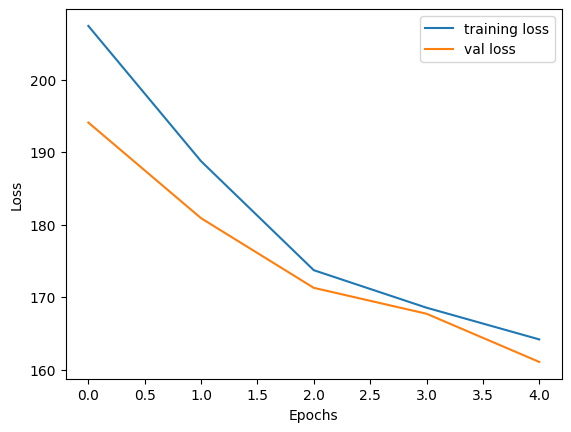

In [8]:
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.ylabel('Loss')

plt.xlabel('Epochs')
plt.legend()

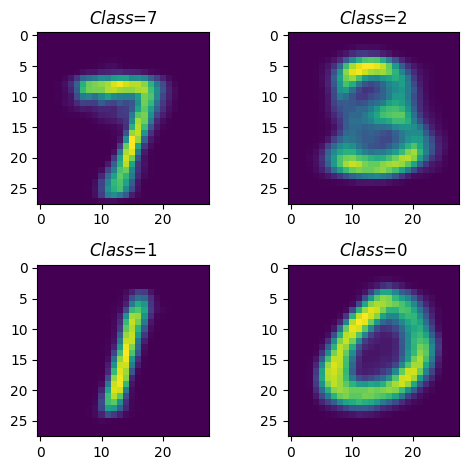

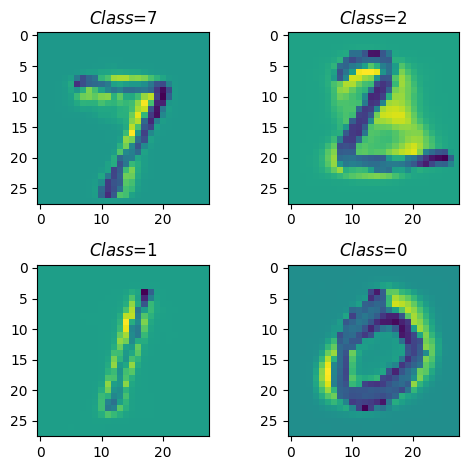

In [9]:
if variational:
    #z = prior.sample(10)
    #xtilde = decoder(z)
    pred = ae(x_test[0:10]/255.).mean()

else:
    pred = ae(x_test[0:10]/255.)

fig = plt.figure()
for i,j in zip(range(10),range(4)):
    ax = fig.add_subplot(2, 2, j+1)
    im = ax.imshow(pred[i,:,:,0])
    plt.title('$Class$='+str(y_test[i]))
    fig.tight_layout()

fig = plt.figure()
for i,j in zip(range(10),range(4)):
    ax = fig.add_subplot(2, 2, j+1)
    im = ax.imshow(pred[i,:,:,0]-x_test[i]/255.)
    plt.title('$Class$='+str(y_test[i]))
    fig.tight_layout()


shape of encoded space: (10000, 10)


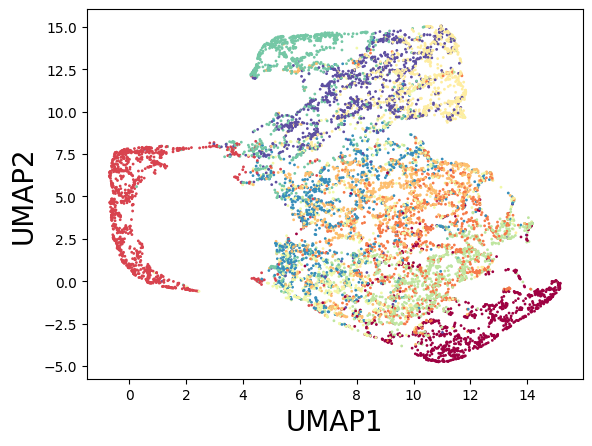

In [10]:
if variational:
    z = encoder_(x_test).mean()
else:
    z = encoder_(x_test)

print("shape of encoded space:", z.shape)


reducer = umap.UMAP()
embedding = reducer.fit_transform(z)
embedding.shape

plt.xlabel("UMAP1", fontsize=20)
plt.ylabel("UMAP2", fontsize=20)

plt.scatter(embedding[:,0], embedding[:,1], c=y_test, cmap='Spectral', s=1)


